In [72]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
#import statsmodels.api as sm
#from statsmodels.iolib.summary2 import summary_col
#from statsmodels.sandbox.stats.multicomp import multipletefasts
from nilearn.mass_univariate import permuted_ols

%matplotlib inline

#use seaborn to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join

from scipy.stats import ttest_rel
#from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel,  wilcoxon, mannwhitneyu
#import statsmodels as sm
from statsmodels import stats

In [2]:
#read in data
base_dir = '/home/data/nbc/physics-learning/data/behavioral-data/analyses/physics-learning-behavioral'
data_dir = join(base_dir, 'datafiles')
fig_dir = join(base_dir, 'plots')

fci_df = pd.read_csv(join(base_dir, data_dir, 'fci_accuracy_rt_gender_class.txt'), sep='\t', 
                      index_col=0, header=0, skipfooter=1, engine='python')
pk_df = pd.read_csv(join(base_dir, data_dir, 'retr_physcond_accuracy_by_gender.txt'), sep='\t', 
                      index_col=0, header=0, skipfooter=1, engine='python')
ti_df = pd.read_csv(join(base_dir, data_dir, 'reas_accuracy_by_gender.txt'), sep='\t', 
                      index_col=0, header=0, skipfooter=1, engine='python')
grade_df = pd.read_csv(join(base_dir, data_dir, 'coursegrades.csv'), sep='\t', 
                      index_col=0, header=0, skipfooter=1, engine='python')
group_df = pd.read_csv(join(base_dir, data_dir, 'c123456-demographics.txt'), sep='\t', 
                      index_col=0, header=0, skipfooter=1, engine='python')

In [3]:
##wrangle data
#if df indices are subject IDs then make 'Subject' its own column
ti_df['Subject'] = ti_df.index
grade_df['Subject'] = grade_df.index
group_df['Subject'] = group_df.index

ti_df = ti_df.reset_index(drop=True)
grade_df = grade_df.reset_index(drop=True)
group_df = group_df.reset_index(drop=True)
pk_df = pk_df.reset_index(drop=True)

In [4]:
##check if IDs of participants who did not complete study are in df
#group_df = group_df.rename(columns={'Cmp.Stdy': 'CmpStdy'})
#a = group_df.loc[group_df['CmpStdy'] == 'N', 'Subject']
#
#for item in a:
#    print(fci_df[fci_df['Subject'].astype(str).str.contains('{}'.format(item))])

In [5]:
##remove unnecessary columns and rows
#remove row if participant did not complete study
group_df = group_df.rename(columns={'Cmp.Stdy': 'CmpStdy'})
nc_ids = group_df.loc[group_df['CmpStdy'] == 'N', 'Subject']
for sub in nc_ids:
    fci_df = fci_df[fci_df.Subject != sub]
    pk_df = pk_df[pk_df.Subject != sub]
    ti_df = ti_df[ti_df.Subject != sub]
    grade_df = grade_df[grade_df.Subject != sub]    
group_df = group_df[group_df.CmpStdy != 'N']

#remove column if not needed for plotting
str_rm = ('RT', 'Non-FCI', 'Control', 'Correct', 'Incorrect', 'CmpStdy')
dfs = (fci_df, pk_df, ti_df, grade_df, group_df)
for df in dfs:
    for str_ in str_rm:
        cols = [c for c in fci_df.columns if not str_ in c]
        fci_df = fci_df[cols]
        cols = [c for c in pk_df.columns if not str_ in c]
        pk_df = pk_df[cols]
        cols = [c for c in ti_df.columns if not str_ in c]
        ti_df = ti_df[cols]
        cols = [c for c in group_df.columns if not str_ in c]
        group_df = group_df[cols]

In [6]:
##rename cols and elements for consistency
fci_df = fci_df.rename(columns={'Mean FCI Accuracy': 'FCI Accuracy'})
fci_df = fci_df.rename(columns={'Gender': 'Sex'})
pk_df = pk_df.rename(columns={'Mean Physics Retrieval Accuracy': 'PK Accuracy'})
pk_df = pk_df.rename(columns={'Gender': 'Sex'})
ti_df = ti_df.rename(columns={'Mean Reasoning Accuracy': 'TI Accuracy'})
ti_df = ti_df.rename(columns={'Gender': 'Sex'})
grade_df = grade_df.rename(columns={'CourseGrade': 'Course Grade'})
group_df = group_df.rename(columns={'Group': 'Class'})
group_df = group_df.rename(columns={'Gender': 'Sex'})
    
fci_df = fci_df.replace('session-0', 'Pre')
fci_df = fci_df.replace('session-1', 'Post')

pk_df = pk_df.rename(columns={"Gender And Class": "Group"})
grade_df = grade_df.rename(columns={"ID": "Subject"})
group_df = group_df.rename(columns={"PID": "Subject"})

fci_df = fci_df.replace('F_Trad', 'Female LI')
fci_df = fci_df.replace('M_Trad', 'Male LI')
fci_df = fci_df.replace('F_Mod', 'Female MI')
fci_df = fci_df.replace('M_Mod', 'Male MI')
fci_df = fci_df.replace('Mod', 'MI')
fci_df = fci_df.replace('Trad', 'LI')

group_df = group_df.replace('Mod', 'MI')
group_df = group_df.replace('Trad', 'LI')

pk_df = pk_df.replace('Lecture F', 'Female LI')
pk_df = pk_df.replace('Lecture M', 'Male LI')
pk_df = pk_df.replace('Modeling F', 'Female MI')
pk_df = pk_df.replace('Modeling M', 'Male MI')
pk_df = pk_df.replace('Lecture', 'LI')
pk_df = pk_df.replace('Modeling', 'MI')
pk_df = pk_df.replace('pre', 'Pre')
pk_df = pk_df.replace('post', 'Post')

ti_df = ti_df.replace('pre', 'Pre')
ti_df = ti_df.replace('post', 'Post')

In [7]:
##add columns as needed
#add col for measure type
fci_df['Measure'] = 'FCI Accuracy'
pk_df['Measure'] = 'PK Accuracy'
ti_df['Measure'] = 'TI Accuracy'
grade_df['Measure'] = 'Course Grade'

#add class and sex col to ti_df
new_ti_df = group_df.merge(ti_df, how='left', on='Subject')
ti_df = new_ti_df
ti_df = ti_df.rename(columns={'Sex_x': 'Sex'})
ti_df.drop(columns=['Sex_y'])

#add class and sex col to grade_df
new_grade_df = group_df.merge(grade_df, how='left', on='Subject')
grade_df = new_grade_df
grade_df = grade_df.rename(columns={'Sex_x': 'Sex'})

In [8]:
#number of female and males
n = group_df.Sex.value_counts()
print(n)

print(fci_df.head())
print('_____________________________________________________________________')
print(pk_df.head())
print('_____________________________________________________________________')
print(ti_df.head())
print('_____________________________________________________________________')
print(grade_df.head())
print('_____________________________________________________________________')
#print(group_df.head())
#print('_____________________________________________________________________')

M    59
F    47
Name: Sex, dtype: int64
   Subject Session  FCI Accuracy Sex Class      Group       Measure
0      101     Pre      0.333333   F    LI  Female LI  FCI Accuracy
1      101    Post      0.444444   F    LI  Female LI  FCI Accuracy
2      102     Pre      0.222222   M    MI    Male MI  FCI Accuracy
3      102    Post      0.555556   M    MI    Male MI  FCI Accuracy
4      103     Pre      0.444444   M    LI    Male LI  FCI Accuracy
_____________________________________________________________________
   Subject Session  PK Accuracy Sex Class      Group      Measure
0      101     Pre     0.708333   F    LI  Female LI  PK Accuracy
1      101    Post     0.750000   F    LI  Female LI  PK Accuracy
2      102     Pre     0.541667   M    MI    Male MI  PK Accuracy
3      102    Post     0.833333   M    MI    Male MI  PK Accuracy
4      103     Pre     0.750000   M    LI    Male LI  PK Accuracy
_____________________________________________________________________
  Sex Class  Sub

In [11]:
##Color palettes
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

f = sns.diverging_palette(8.2, 44, s=85, l=50, n=200)
m = sns.diverging_palette(243, 278, s=85, l=50, n=200)


<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


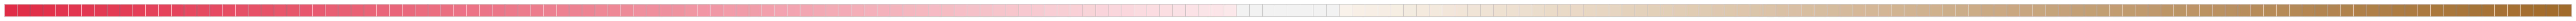

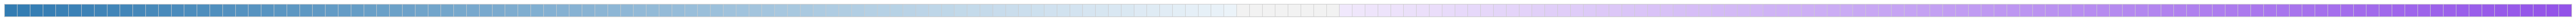

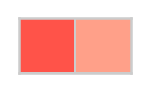

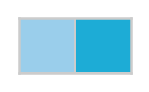

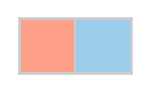

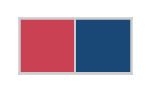

In [12]:
sns.palplot(f)
sns.palplot(m)

sns.palplot(f_2)
sns.palplot(m_2)

sns.palplot(crayons_l)
sns.palplot(crayons_d)

In [13]:
corrfonty = {'fontsize': 12,
             'fontweight': 'bold',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 12,
             'fontweight': 'bold',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

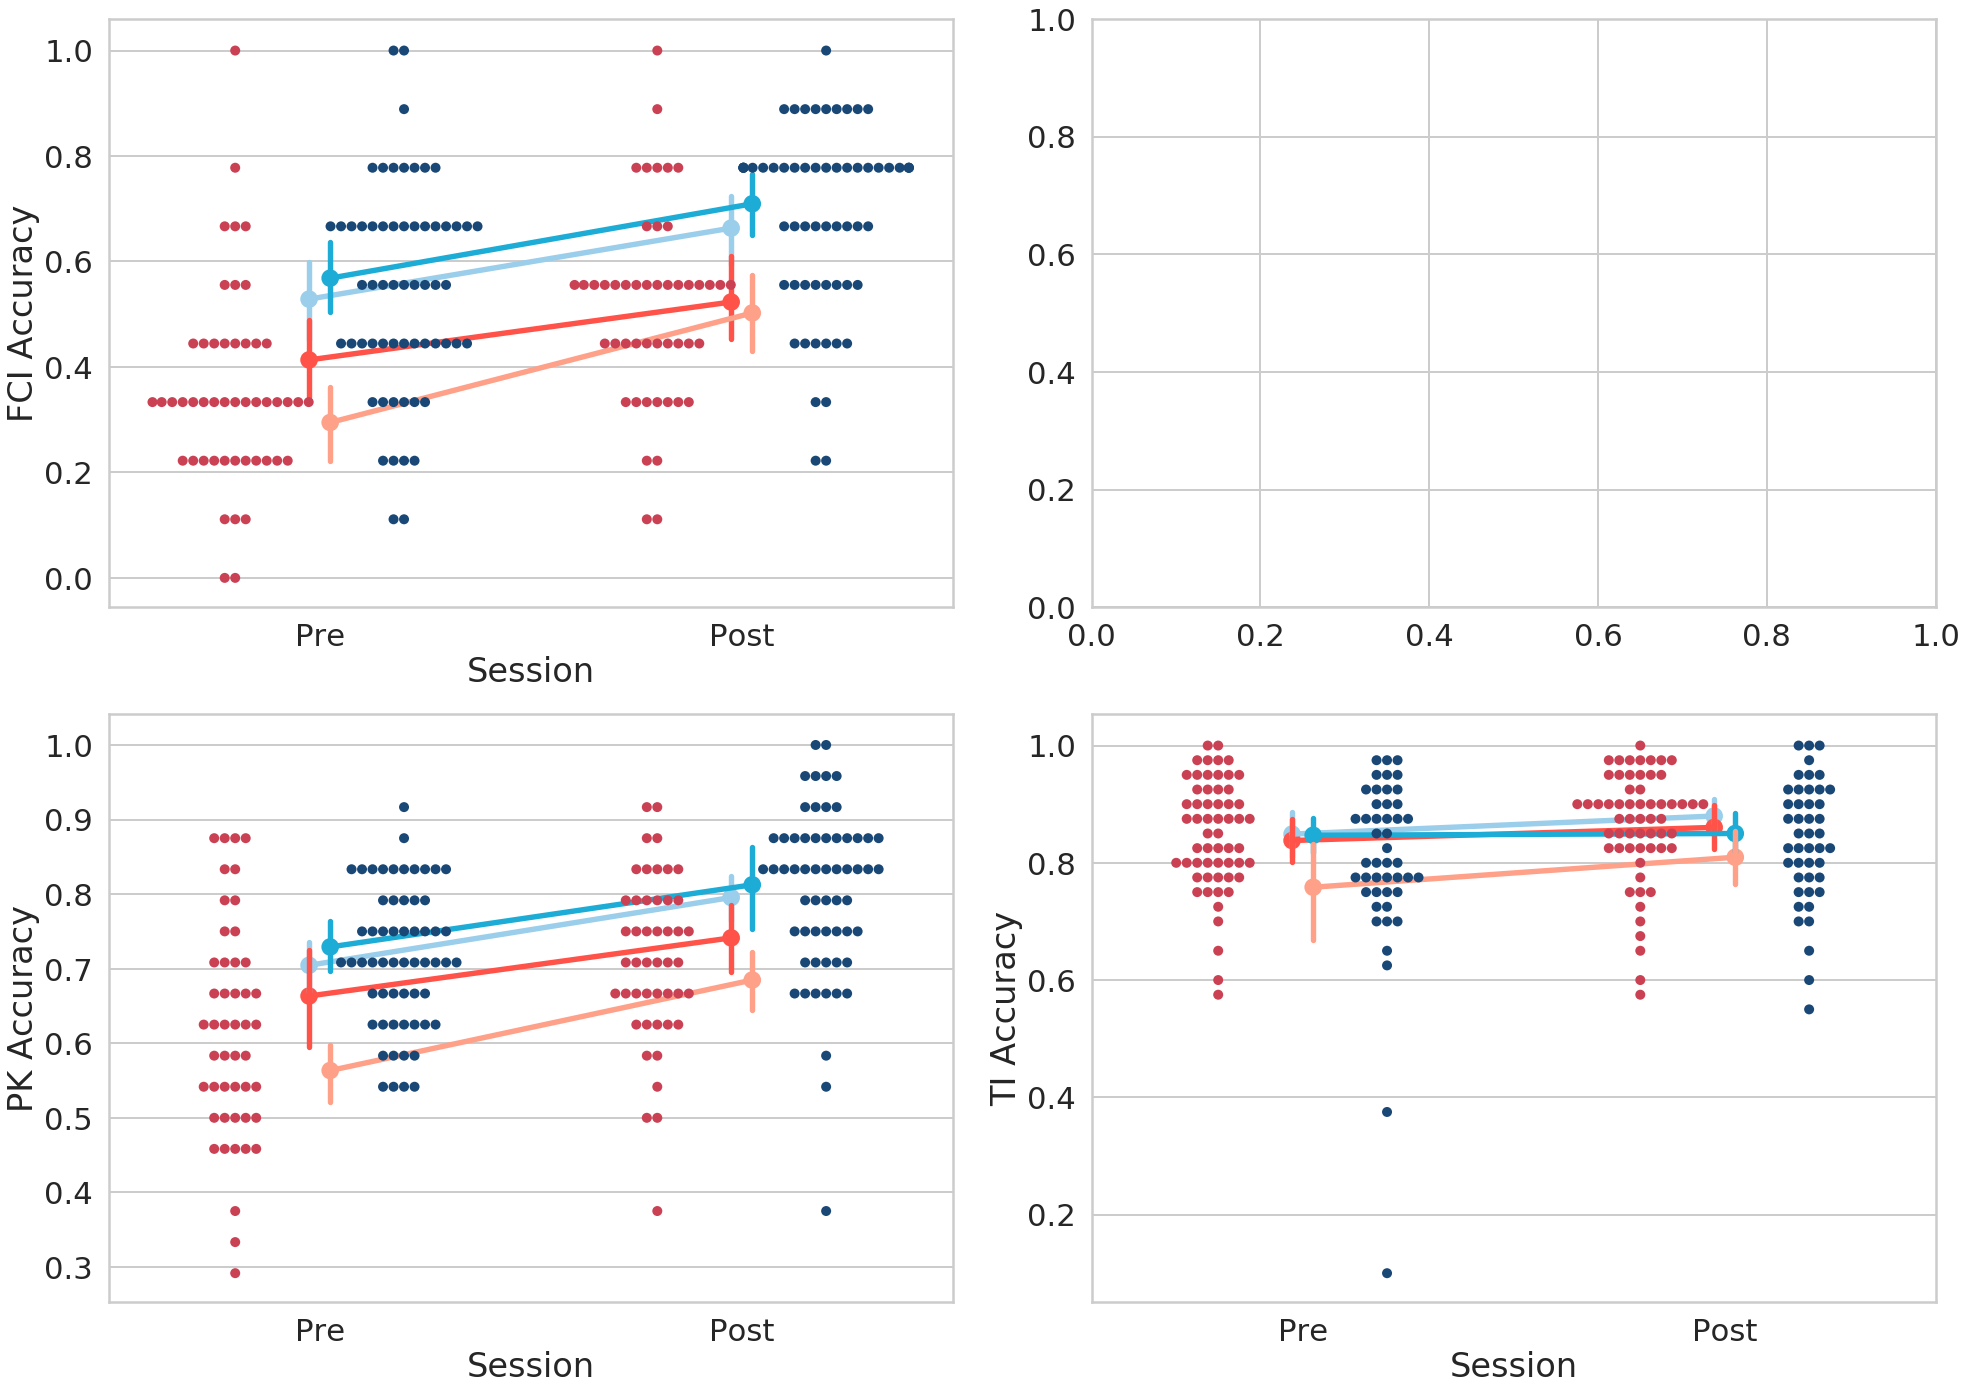

In [15]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(28, 20), sharex=False, sharey=False, squeeze=True)
mksz = 10
plt.tight_layout(pad=5)

#line plots
h = sns.pointplot(x='Session', y='FCI Accuracy', hue='Class', data=fci_df[fci_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][0], size=mksz, dodge=True)
h = sns.pointplot(x='Session', y='FCI Accuracy', hue='Class', data=fci_df[fci_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][0], size=mksz, dodge=True)
h.get_legend().set_visible(False)

i = sns.pointplot(x='Session', y='PK Accuracy', hue='Class', data=pk_df[pk_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][0], size=mksz, dodge=True)
i = sns.pointplot(x='Session', y='PK Accuracy', hue='Class', data=pk_df[pk_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][0], size=mksz, dodge=True)
i.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='TI Accuracy', hue='Class', data=ti_df[ti_df['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][1], size=mksz, dodge=True)
j = sns.pointplot(x='Session', y='TI Accuracy', hue='Class', data=ti_df[ti_df['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][1], size=mksz, dodge=True)
j.get_legend().set_visible(False)

#k = sns.pointplot(x='Sex', y='Course Grade', hue='Sex', data=grade_df[grade_df['Class'] == 'LI'], 
#              palette=m_2, ax=ax[1][1], size=mksz, dodge=True)
#k = sns.pointplot(x='Sex', y='Course Grade', hue='Sex', data=grade_df[grade_df['Class'] == 'MI'], 
#              palette=f_2, ax=ax[1][1], size=mksz, dodge=True)
#k.get_legend().set_visible(False)


#scatter plots
h = sns.swarmplot(x='Session', y='FCI Accuracy', hue='Sex', data=fci_df, 
              palette=crayons_d, ax=ax[0][0], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='PK Accuracy', hue='Sex', data=pk_df, 
              palette=crayons_d, ax=ax[1][0], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='TI Accuracy', hue='Sex', data=ti_df, 
              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
j.get_legend().set_visible(False)
#k = sns.swarmplot(x='Class', y='Course Grade', hue='Class', data=grade_df, 
#              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
#k.get_legend().set_visible(False)


fig.savefig(join(base_dir, fig_dir, 'alltasks_acc_sexclass.png'), dpi=300)

In [53]:
##Check individual group t-tests across time
#Running a total of 8 tests

#filter dfs to get one for each group
#fci
is_fli_fci =  fci_df['Group']=="Female LI"
fli_fci_df = fci_df[is_fli_fci]
fli_fci_df = fli_fci_df[fli_fci_df.Subject != 634]

is_mli_fci =  fci_df['Group']=="Male LI"
mli_fci_df = fci_df[is_mli_fci]

is_fmi_fci =  fci_df['Group']=="Female MI"
fmi_fci_df = fci_df[is_fmi_fci]

is_mmi_fci =  fci_df['Group']=="Male MI"
mmi_fci_df = fci_df[is_mmi_fci]

#pk
is_fli_pk =  pk_df['Group']=="Female LI"
fli_pk_df = pk_df[is_fli_pk]
fli_pk_df = fli_pk_df[fli_pk_df.Subject != 634]

is_mli_pk =  pk_df['Group']=="Male LI"
mli_pk_df = pk_df[is_mli_pk]

is_fmi_pk =  pk_df['Group']=="Female MI"
fmi_pk_df = pk_df[is_fmi_pk]

is_mmi_pk =  pk_df['Group']=="Male MI"
mmi_pk_df = pk_df[is_mmi_pk]

#filter dfs to get one for each groups' session
#fci
is_fli_fci_pre =  fli_fci_df['Session']=="Pre"
fli_fci_pre_df = fli_fci_df[is_fli_fci_pre]

is_fli_fci_post =  fli_fci_df['Session']=="Post"
fli_fci_post_df = fli_fci_df[is_fli_fci_post]

is_mli_fci_pre =  mli_fci_df['Session']=="Pre"
mli_fci_pre_df = mli_fci_df[is_mli_fci_pre]

is_mli_fci_post =  mli_fci_df['Session']=="Post"
mli_fci_post_df = mli_fci_df[is_mli_fci_post]

is_fmi_fci_pre =  fmi_fci_df['Session']=="Pre"
fmi_fci_pre_df = fmi_fci_df[is_fmi_fci_pre]

is_fmi_fci_post =  fmi_fci_df['Session']=="Post"
fmi_fci_post_df = fmi_fci_df[is_fmi_fci_post]

is_mmi_fci_pre =  mmi_fci_df['Session']=="Pre"
mmi_fci_pre_df = mmi_fci_df[is_mmi_fci_pre]

is_mmi_fci_post =  mmi_fci_df['Session']=="Post"
mmi_fci_post_df = mmi_fci_df[is_mmi_fci_post]

#pk
is_fli_pk_pre =  fli_pk_df['Session']=="Pre"
fli_pk_pre_df = fli_pk_df[is_fli_pk_pre]

is_fli_pk_post =  fli_pk_df['Session']=="Post"
fli_pk_post_df = fli_pk_df[is_fli_pk_post]

is_mli_pk_pre =  mli_pk_df['Session']=="Pre"
mli_pk_pre_df = mli_pk_df[is_mli_pk_pre]

is_mli_pk_post =  mli_pk_df['Session']=="Post"
mli_pk_post_df = mli_pk_df[is_mli_pk_post]

is_fmi_pk_pre =  fmi_pk_df['Session']=="Pre"
fmi_pk_pre_df = fmi_pk_df[is_fmi_pk_pre]

is_fmi_pk_post =  fmi_pk_df['Session']=="Post"
fmi_pk_post_df = fmi_pk_df[is_fmi_pk_post]

is_mmi_pk_pre =  mmi_pk_df['Session']=="Pre"
mmi_pk_pre_df = mmi_pk_df[is_mmi_pk_pre]

is_mmi_pk_post =  mmi_pk_df['Session']=="Post"
mmi_pk_post_df = mmi_pk_df[is_mmi_pk_post]

print(fli_fci_pre_df.head())
print('_____________________________________________________________________')
print(fli_fci_post_df.head())
print('_____________________________________________________________________')
print(mli_fci_pre_df.head())
print('_____________________________________________________________________')
print(mli_fci_post_df.head())
print('_____________________________________________________________________')
print(fmi_fci_pre_df.head())
print('_____________________________________________________________________')
print(fmi_fci_post_df.head())
print('_____________________________________________________________________')
print(mmi_fci_pre_df.head())
print('_____________________________________________________________________')
print(mmi_fci_post_df.head())
print('_____________________________________________________________________')

print(fli_pk_pre_df.head())
print('_____________________________________________________________________')
print(fli_pk_post_df.head())
print('_____________________________________________________________________')
print(mli_pk_pre_df.head())
print('_____________________________________________________________________')
print(mli_pk_post_df.head())
print('_____________________________________________________________________')
print(fmi_pk_pre_df.head())
print('_____________________________________________________________________')
print(fmi_pk_post_df.head())
print('_____________________________________________________________________')
print(mmi_pk_pre_df.head())
print('_____________________________________________________________________')
print(mmi_pk_post_df.head())
print('_____________________________________________________________________')

    Subject Session  FCI Accuracy Sex Class      Group       Measure
0       101     Pre      0.333333   F    LI  Female LI  FCI Accuracy
10      107     Pre      0.333333   F    LI  Female LI  FCI Accuracy
12      108     Pre      0.444444   F    LI  Female LI  FCI Accuracy
23      216     Pre      0.444444   F    LI  Female LI  FCI Accuracy
27      218     Pre      0.222222   F    LI  Female LI  FCI Accuracy
_____________________________________________________________________
    Subject Session  FCI Accuracy Sex Class      Group       Measure
1       101    Post      0.444444   F    LI  Female LI  FCI Accuracy
11      107    Post      0.444444   F    LI  Female LI  FCI Accuracy
13      108    Post      0.555556   F    LI  Female LI  FCI Accuracy
24      216    Post      0.555556   F    LI  Female LI  FCI Accuracy
28      218    Post      0.555556   F    LI  Female LI  FCI Accuracy
_____________________________________________________________________
    Subject Session  FCI Accurac

In [99]:
fli_fci_statistic, fli_fci_pvalue = ttest_rel(fli_fci_pre_df['FCI Accuracy'], 
                                              fli_fci_post_df['FCI Accuracy'])
mli_fci_statistic, mli_fci_pvalue = ttest_rel(mli_fci_pre_df['FCI Accuracy'], 
                                              mli_fci_post_df['FCI Accuracy'])
fmi_fci_statistic, fmi_fci_pvalue = ttest_rel(fmi_fci_pre_df['FCI Accuracy'], 
                                              fmi_fci_post_df['FCI Accuracy'])
mmi_fci_statistic, mmi_fci_pvalue = ttest_rel(mmi_fci_pre_df['FCI Accuracy'], 
                                              mmi_fci_post_df['FCI Accuracy'])

fli_pk_statistic, fli_pk_pvalue = ttest_rel(fli_pk_pre_df['PK Accuracy'], 
                                            fli_pk_post_df['PK Accuracy'])
mli_pk_statistic, mli_pk_pvalue = ttest_rel(mli_pk_pre_df['PK Accuracy'], 
                                            mli_pk_post_df['PK Accuracy'])
fmi_pk_statistic, fmi_pk_pvalue = ttest_rel(fmi_pk_pre_df['PK Accuracy'], 
                                            fmi_pk_post_df['PK Accuracy'])
mmi_pk_statistic, mmi_pk_pvalue = ttest_rel(mmi_pk_pre_df['PK Accuracy'], 
                                            mmi_pk_post_df['PK Accuracy'])

pvals = [fli_fci_pvalue, mli_fci_pvalue, fmi_fci_pvalue, mmi_fci_pvalue, 
         fli_pk_pvalue, mli_pk_pvalue, fmi_pk_pvalue, mmi_pk_pvalue]
pvals_list = ("fli_fci", "mli_fci", "fmi_fci", "mmi_fci", 
         "fli_pk", "mli_pk", "fmi_pk", "mmi_pk")

sig_01 = stats.multitest.multipletests(pvals, alpha=0.01, method='bonferroni', 
                                 is_sorted=False, returnsorted=False)
sig_001 = stats.multitest.multipletests(pvals, alpha=0.001, method='bonferroni', 
                                 is_sorted=False, returnsorted=False)

for index, value in enumerate(pvals_list):
    if sig_001[0][index] == True:
        print(value, 'Significant P < 0.001')
    elif sig_001[0][index] == False:
        if sig_01[0][index] == True:
            print(value, 'Significant P < 0.01')
        else:
            print(value, 'Not significant at P < 0.01')

fli_fci Not significant at P < 0.01
mli_fci Significant P < 0.01
fmi_fci Significant P < 0.001
mmi_fci Significant P < 0.01
fli_pk Not significant at P < 0.01
mli_pk Significant P < 0.01
fmi_pk Significant P < 0.001
mmi_pk Significant P < 0.001
